In [201]:
!uv pip install -r requirements.txt

Using Python 3.12.4 environment at: C:\Users\jefer\anaconda3
Audited 12 packages in 3.64s


In [276]:
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from typing import Annotated, List
from langchain_core.messages import HumanMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    SystemMessage
)
from langgraph.graph.message import add_messages



load_dotenv()

chat = ChatGroq(
    model="meta-llama/llama-4-maverick-17b-128e-instruct",
    temperature=0
)

class State(TypedDict):
    messages: Annotated[list, add_messages]
    
prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="""You are a helpful assistant that can answer any question. 
                      You can also say 'I don't know' if you don't know the answer.
                      Your answer should be in Portuguese."""),
        HumanMessagePromptTemplate.from_template("{input}"),
    ]
)


def chat_groq(state):
    message = state['messages'][-1]
    response = chat.invoke(prompt_template.format(input=message))
    return {"messages": response.content}
    

In [277]:
response = chat.invoke("Tudo bem com vc")

In [279]:
response.content

'Estou bem, obrigado por perguntar! Sou um modelo de linguagem treinado por máquina, então não tenho sentimentos ou emoções como os humanos, mas estou funcionando corretamente e pronto para ajudar com qualquer coisa que você precise. Como posso ajudar você hoje?'

In [280]:
response = chat_groq({"messages": ["Tudo bem com vc"]})
response

{'messages': 'Tudo bem, obrigado por perguntar! Estou aqui para ajudar com qualquer coisa que você precise. Como posso ajudar você hoje?'}

In [284]:
graph = StateGraph(State)

graph.add_node("chat_groq", chat_groq)
graph.add_edge(START, "chat_groq")
graph.add_edge("chat_groq", END)

graph_compiled = graph.compile()

In [286]:
graph_compiled.invoke({"messages": "que dia e hoje"})

{'messages': [HumanMessage(content='que dia e hoje', additional_kwargs={}, response_metadata={}, id='fdbaf679-4002-4c71-b07b-8d83bf66916a'),
  HumanMessage(content='Hoje é sexta-feira, 19 de abril de 2024. (Se você quiser saber a data atual, eu posso fornecer. Mas, por favor, note que minha data pode não estar atualizada.)', additional_kwargs={}, response_metadata={}, id='7488696d-f0a3-44fa-8e2e-641c1e078543')]}

### Connect to your deployment

Connect to your deployment using the URL endpoint:
- **Studio**: Found in Studio UI 
- **CLI**: Printed to console (typically `http://localhost:2024`)
- **Cloud**: Available in LangGraph Deployment page

We'll connect to the deployment as a [RemoteGraph](https://langchain-ai.github.io/langgraph/how-tos/use-remote-graph/#how-to-interact-with-the-deployment-using-remotegraph). 

In [ ]:
from langgraph.pregel.remote import RemoteGraph
from langchain_core.messages import convert_to_messages
from langchain_core.messages import HumanMessage, SystemMessage

# Local deployment (via LangGraph Studio)
local_deployment_url = "http://localhost:2024"

# Deployment URL
#cloud_deployment_url = "https://task-maistro-1b681add7a2b549499bb0cd21a7e5be4.default.us.langgraph.app"

# Graph name
graph_name = "audio-langgraph" 

# Connect to the deployment
remote_graph = RemoteGraph(graph_name, url=local_deployment_url)

In [37]:
# Int
user_input = "Hi I'm Lance. I live in San Francisco with my wife and have a 1 year old."
config = {"configurable": {"user_id": "Test-Deployment-User"}}
for chunk in remote_graph.stream({"messages": user_input}, stream_mode="values", config=config):
    print(chunk["messages"])

[{'content': "Hi I'm Lance. I live in San Francisco with my wife and have a 1 year old.", 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '426611bf-8e95-4d0a-b8c5-cc2b990dc131', 'example': False}]
[{'content': "Hi I'm Lance. I live in San Francisco with my wife and have a 1 year old.", 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '426611bf-8e95-4d0a-b8c5-cc2b990dc131', 'example': False}, {'content': 'Olá Lance! É um prazer conhecê-lo. Parece que você tem uma vida muito interessante em San Francisco com sua esposa e seu filho de 1 ano. Como posso ajudá-lo hoje? Você tem alguma pergunta ou precisa de alguma informação específica? Estou aqui para ajudar!', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '9cb40f59-4720-440f-a02c-1f66d7346808', 'example': False}]


### Add audio

Our deployed graph has some benefits: 
* It has built-in support for long-term memory 
* It implements all the logic for task mAIstro 

But, we have a challenge:
* It takes test as input and returns text as output

We need to add audio input and output to the graph. So, we'll simply add two nodes to our graph:

1. **Audio Input Node**
   * Records microphone input (stop with Enter)
   * Transcribes speech using Whisper
   * Passes text to Task mAIstro

2. **Audio Output Node**
   * Takes Task mAIstro's text response
   * Converts to speech via ElevenLabs
   * Plays audio response

We can achieve this by embedding our deployed graph [as a node](https://langchain-ai.github.io/langgraph/how-tos/use-remote-graph/#using-as-a-subgraph) in a new graph. 

In [ ]:
import io
import threading
import numpy as np
import sounddevice as sd
from scipy.io.wavfile import write
from IPython.display import Image, display
import pygame
import tempfile
import os
from groq import Groq
from langgraph.graph import StateGraph, MessagesState, END, START
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser

from dotenv import load_dotenv
load_dotenv()

# Initialize Groq client
groq_client = Groq()

def record_audio_until_stop(state: State):
    """Records audio from the microphone until Enter is pressed, then saves it to a .wav file."""
    
    audio_data = []  # List to store audio chunks
    recording = True  # Flag to control recording
    sample_rate = 16000  # (kHz) Adequate for human voice frequency
    
    def record_audio():
        """Continuously records audio until the recording flag is set to False."""
        nonlocal audio_data, recording
        with sd.InputStream(samplerate=sample_rate, channels=1, dtype='int16') as stream:
            print("Recording your instruction! ... Press Enter to stop recording.")
            while recording:
                audio_chunk, _ = stream.read(1024)  # Read audio data in chunks
                audio_data.append(audio_chunk)

    def stop_recording():
        """Waits for user input to stop the recording."""
        input()  # Wait for Enter key press
        nonlocal recording
        recording = False

    # Start recording in a separate thread
    recording_thread = threading.Thread(target=record_audio)
    recording_thread.start()

    # Start a thread to listen for the Enter key
    stop_thread = threading.Thread(target=stop_recording)
    stop_thread.start()

    # Wait for both threads to complete
    stop_thread.join()
    recording_thread.join()

    # Stack all audio chunks into a single NumPy array and write to file
    audio_data = np.concatenate(audio_data, axis=0)
    
    # Create a temporary WAV file for Groq API
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_file:
        write(temp_file.name, sample_rate, audio_data)
        temp_filename = temp_file.name
    
    try:
        # Transcribe via Groq Whisper
        with open(temp_filename, "rb") as file:
            transcription = groq_client.audio.transcriptions.create(
                file=(temp_filename, file.read()),
                model="whisper-large-v3",
                prompt="Transcreva o áudio em português brasileiro",
                response_format="json",
                temperature=0.0
            )
    finally:
        # Clean up temporary file
        os.unlink(temp_filename)
    
    # Print the transcription
    print("Here is the transcription:", transcription.text)
    
    # Write to messages 
    return {"messages": [HumanMessage(content=transcription.text)]}

def play_audio(state: State):
    """Plays the audio response using Groq TTS."""
    
    # Response from the agent 
    response = state['messages'][-1]
    
    # Prepare text by replacing ** with empty strings
    # These can cause unexpected behavior in TTS
    if isinstance(response, str):
        cleaned_text = response.replace("**", "")
    else:
        cleaned_text = response.content.replace("**", "")
    
    try:
        # Call Groq text-to-speech API
        tts_response = groq_client.audio.speech.create(
            model="playai-tts",
            voice="Atlas-PlayAI",  # You can change this to other available voices
            input=cleaned_text,
            response_format="wav"
        )
    
        with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_file:
            tts_response.write_to_file(temp_file.name)
            temp_audio_file = temp_file.name
        
        # Play the audio using pygame
        pygame.mixer.init()
        pygame.mixer.music.load(temp_audio_file)
        pygame.mixer.music.play()
        
        # Wait for the audio to finish playing
        while pygame.mixer.music.get_busy():
            pygame.time.wait(100)
            
    except Exception as e:
        print(f"Error in text-to-speech: {e}")
    finally:
        # Clean up temporary file
        if 'temp_audio_file' in locals():
            try:
                os.unlink(temp_audio_file)
            except:
                pass

# Alternative play_audio function using sounddevice (if pygame doesn't work)
def play_audio_alternative(state: State):
    """Alternative audio playback using sounddevice."""
    
    response = state['messages'][-1]
    if isinstance(response, str):
        cleaned_text = response.replace("**", "")
    else:
        cleaned_text = response.content.replace("**", "")
    try:
        # Call Groq text-to-speech API
        tts_response = groq_client.audio.speech.create(
            model="playai-tts",
            voice="Arista-PlayAI",
            input=cleaned_text,
            response_format="wav"
        )
        
        # Create temporary file and read audio data
        with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_file:
            tts_response.write_to_file(temp_file.name)
            temp_audio_file = temp_file.name
        
        # Read the WAV file and play with sounddevice
        from scipy.io.wavfile import read
        sample_rate, audio_data = read(temp_audio_file)
        sd.play(audio_data, sample_rate)
        sd.wait()  # Wait until the audio finishes playing
        
    except Exception as e:
        print(f"Error in text-to-speech: {e}")
    finally:
        # Clean up
        if 'temp_audio_file' in locals():
            try:
                os.unlink(temp_audio_file)
            except:
                pass
            
# choco install ffmpeg
# site para vozes https://elevenlabs.io/app/voice-library?search=brazil
from dotenv import load_dotenv
from elevenlabs.client import ElevenLabs
from elevenlabs import play
import os

load_dotenv()

elevenlabs = ElevenLabs(
  api_key=os.getenv("ELEVENLABS_API_KEY"),
)

def play_audio(state: State):
    """Plays the audio response using Groq TTS."""
    
    # Response from the agent 
    response = state['messages'][-1]
    
    # Prepare text by replacing ** with empty strings
    # These can cause unexpected behavior in TTS
    if isinstance(response, str):
        cleaned_text = response.replace("**", "")
    else:
        cleaned_text = response.content.replace("**", "")

    try:
        audio = elevenlabs.text_to_speech.convert(
            text=cleaned_text,
            #voice_id="JBFqnCBsd6RMkjVDRZzb",
            #model_id="eleven_multilingual_v2",
            #voice_id="GnDrTQvdzZ7wqAKfLzVQ",
            #voice_id = "8ydzsJeYlXGq5mRMX93B",
            voice_id="EIkHVdkuarjkYUyMnoes",
            
            model_id="eleven_multilingual_v1",
            output_format="mp3_44100_128",
        )

        play(audio)
    except Exception as e:
        print(f"Error in elevenlabs: {e}")
        try:
            # Call Groq text-to-speech API
            tts_response = groq_client.audio.speech.create(
                model="playai-tts",
                voice="Arista-PlayAI",
                input=cleaned_text,
                response_format="wav"
            )
            
            # Create temporary file and read audio data
            with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_file:
                tts_response.write_to_file(temp_file.name)
                temp_audio_file = temp_file.name
            
            # Read the WAV file and play with sounddevice
            from scipy.io.wavfile import read
            sample_rate, audio_data = read(temp_audio_file)
            sd.play(audio_data, sample_rate)
            sd.wait()  # Wait until the audio finishes playing
            
        except Exception as e:
            print(f"Error in text-to-speech: {e}")
        finally:
            # Clean up
            if 'temp_audio_file' in locals():
                try:
                    os.unlink(temp_audio_file)
                except:
                    pass


from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from typing import List, Annotated
from langchain_core.messages import HumanMessage
from langgraph.graph.message import add_messages
load_dotenv()

chat = ChatGroq(
    model="meta-llama/llama-4-maverick-17b-128e-instruct",
    temperature=0
)

class State(TypedDict):
    messages: Annotated[list, add_messages]
    
prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="""You are a helpful assistant that can answer any question. 
                      You can also say 'I don't know' if you don't know the answer.
                      Your answer should be in Portuguese."""),
        HumanMessagePromptTemplate.from_template("{input}"),
    ]
)


def chat_groq(state):
    message = state['messages'][-1]
    response = chat.invoke(prompt_template.format(input=message))
    return {"messages": response.content}

memory = MemorySaver()
graph = StateGraph(State)
graph.add_node("audio_input", record_audio_until_stop)
graph.add_node("chat_groq", chat_groq)
graph.add_node("audio_output", play_audio)

graph.add_edge(START, "audio_input")
graph.add_edge("audio_input", "chat_groq")
graph.add_edge("chat_groq", "audio_output")
graph.add_edge("audio_output", END)

graph_compiled = graph.compile(checkpointer=memory)

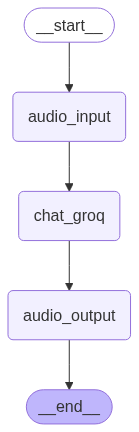

In [292]:
## docker run -p 3000:3000 ghcr.io/jihchi/mermaid.ink 
from IPython.display import Image, display

try:
    display(Image(graph_compiled.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [295]:
import uuid
thread_id = str(uuid.uuid4())


In [297]:
# Set user ID for storing memories
config = {"configurable": {"thread_id": "1"}}

initial_state = {"messages": ["Olá, como você está?"]}
for chunk in graph_compiled.stream({"messages":HumanMessage(content="Follow the user's instructions:")}, stream_mode="values", config=config):
    print(chunk["messages"])

[HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='d2b05ce4-226b-4c9a-8b78-03c9ad3c7725')]
Recording your instruction! ... Press Enter to stop recording.


Here is the transcription:  Olá, tudo bem? Como você está? Olá, tudo bem? Como você está?
[HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='d2b05ce4-226b-4c9a-8b78-03c9ad3c7725'), HumanMessage(content=' Olá, tudo bem? Como você está? Olá, tudo bem? Como você está?', additional_kwargs={}, response_metadata={}, id='4d3633f9-7142-4508-9383-0bd36452c5a4')]
[HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='d2b05ce4-226b-4c9a-8b78-03c9ad3c7725'), HumanMessage(content=' Olá, tudo bem? Como você está? Olá, tudo bem? Como você está?', additional_kwargs={}, response_metadata={}, id='4d3633f9-7142-4508-9383-0bd36452c5a4'), HumanMessage(content='Olá! Estou bem, obrigado por perguntar! Parece que você repetiu a pergunta, mas não há problema. Estou aqui para ajudar e responder às suas perguntas da melhor forma possível. Como posso ajudar você hoje?', additional_kwargs={}, response_metadata={

Here is the transcription:  Olá, tudo bem?
[HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='9896d36a-30fb-4b47-af76-34fcf9685aba'), HumanMessage(content=' Olá, tudo bem?', additional_kwargs={}, response_metadata={}, id='d1e1ccbd-d706-46d3-b394-021a55f0e426')]
[HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='9896d36a-30fb-4b47-af76-34fcf9685aba'), HumanMessage(content=' Olá, tudo bem?', additional_kwargs={}, response_metadata={}, id='d1e1ccbd-d706-46d3-b394-021a55f0e426'), HumanMessage(content='Olá! Sim, tudo bem! Como posso ajudar você hoje?', additional_kwargs={}, response_metadata={}, id='e33ddf6c-02ea-44ca-81ea-3add4fb0101a')]


Here is the transcription:  Olá, tudo bem com você?
[HumanMessage(content=' Olá, tudo bem com você?', additional_kwargs={}, response_metadata={})]
Olá! Sim, estou funcionando corretamente, obrigado por perguntar! Estou aqui para ajudar com qualquer coisa que você precise. Como posso ajudar você hoje?
Error in text-to-speech: Error code: 500 - {'error': {'message': 'Internal Server Error', 'type': 'internal_server_error'}}


Here is the transcription:  Olá, tudo bem? Meu nome é Jefferson.
[HumanMessage(content=' Olá, tudo bem? Meu nome é Jefferson.', additional_kwargs={}, response_metadata={})]
Olá Jefferson! Tudo bem, sim! É um prazer conhecê-lo! Como posso ajudar você hoje?
Error in text-to-speech: Error code: 500 - {'error': {'message': 'Internal Server Error', 'type': 'internal_server_error'}}


In [299]:
for chunk in graph_compiled.stream({"messages":HumanMessage(content="Follow the user's instructions:")}, stream_mode="values", config=config):
    print(chunk["messages"])
    

[HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='d2b05ce4-226b-4c9a-8b78-03c9ad3c7725'), HumanMessage(content=' Olá, tudo bem? Como você está? Olá, tudo bem? Como você está?', additional_kwargs={}, response_metadata={}, id='4d3633f9-7142-4508-9383-0bd36452c5a4'), HumanMessage(content='Olá! Estou bem, obrigado por perguntar! Parece que você repetiu a pergunta, mas não há problema. Estou aqui para ajudar e responder às suas perguntas da melhor forma possível. Como posso ajudar você hoje?', additional_kwargs={}, response_metadata={}, id='c3f96ea2-34d1-4450-a517-1f7e4887c653'), HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='7cb88d3a-54f2-44c0-beb4-4bb5c5d4ebdb')]
Recording your instruction! ... Press Enter to stop recording.


Here is the transcription:  Você sabe que dia é hoje? O que poderia me dizer isso?
[HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='d2b05ce4-226b-4c9a-8b78-03c9ad3c7725'), HumanMessage(content=' Olá, tudo bem? Como você está? Olá, tudo bem? Como você está?', additional_kwargs={}, response_metadata={}, id='4d3633f9-7142-4508-9383-0bd36452c5a4'), HumanMessage(content='Olá! Estou bem, obrigado por perguntar! Parece que você repetiu a pergunta, mas não há problema. Estou aqui para ajudar e responder às suas perguntas da melhor forma possível. Como posso ajudar você hoje?', additional_kwargs={}, response_metadata={}, id='c3f96ea2-34d1-4450-a517-1f7e4887c653'), HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='7cb88d3a-54f2-44c0-beb4-4bb5c5d4ebdb'), HumanMessage(content=' Você sabe que dia é hoje? O que poderia me dizer isso?', additional_kwargs={}, response_metadata={}, id='6604e9db

Here is the transcription:  me fale sobre o clube de futebol do Brasil Palmeiras
[HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='9896d36a-30fb-4b47-af76-34fcf9685aba'), HumanMessage(content=' Olá, tudo bem?', additional_kwargs={}, response_metadata={}, id='d1e1ccbd-d706-46d3-b394-021a55f0e426'), HumanMessage(content='Olá! Sim, tudo bem! Como posso ajudar você hoje?', additional_kwargs={}, response_metadata={}, id='e33ddf6c-02ea-44ca-81ea-3add4fb0101a'), HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='01b3f3a8-1544-49d7-8d1d-a0b82fc39045'), HumanMessage(content=' me fale sobre o clube de futebol do Brasil Palmeiras', additional_kwargs={}, response_metadata={}, id='faf47227-411e-4efe-be88-d58003235ec0')]
[HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='9896d36a-30fb-4b47-af76-34fcf9685aba'), HumanMessage(content=' Olá, tu

Here is the transcription:  Meu nome é Jefferson. Você tem um nome?
[HumanMessage(content=' Meu nome é Jefferson. Você tem um nome?', additional_kwargs={}, response_metadata={})]
Olá Jefferson! É um prazer conhecê-lo. Eu sou um modelo de linguagem, então não tenho um nome pessoal, mas estou aqui para ajudá-lo com qualquer pergunta ou assunto que você queira discutir. Como posso ajudá-lo hoje?
Error in text-to-speech: Error code: 500 - {'error': {'message': 'Internal Server Error', 'type': 'internal_server_error'}}


Here is the transcription:  но все сами мы онове подъеме формат
[HumanMessage(content=' но все сами мы онове подъеме формат', additional_kwargs={}, response_metadata={})]
Похоже, что у вас есть предложение или фраза на русском языке, но она не полностью сформирована или содержит ошибки. Если вы пытаетесь сказать что-то о формате или обсуждении какого-то вопроса, я готов помочь.

Если вы имели в виду обсудить какой-то конкретный формат или тему, пожалуйста, уточните или предоставьте больше контекста, чтобы я мог лучше понять ваш вопрос и дать более точный ответ.
Error in text-to-speech: Error code: 500 - {'error': {'message': 'Internal Server Error', 'type': 'internal_server_error'}}


In [305]:
graph_compiled.invoke({"messages":HumanMessage(content="Follow the user's instructions:")}, config=config)


Recording your instruction! ... Press Enter to stop recording.


Here is the transcription:  você sabe o meu nome por acaso?


{'messages': [HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='d2b05ce4-226b-4c9a-8b78-03c9ad3c7725'),
  HumanMessage(content=' Olá, tudo bem? Como você está? Olá, tudo bem? Como você está?', additional_kwargs={}, response_metadata={}, id='4d3633f9-7142-4508-9383-0bd36452c5a4'),
  HumanMessage(content='Olá! Estou bem, obrigado por perguntar! Parece que você repetiu a pergunta, mas não há problema. Estou aqui para ajudar e responder às suas perguntas da melhor forma possível. Como posso ajudar você hoje?', additional_kwargs={}, response_metadata={}, id='c3f96ea2-34d1-4450-a517-1f7e4887c653'),
  HumanMessage(content="Follow the user's instructions:", additional_kwargs={}, response_metadata={}, id='7cb88d3a-54f2-44c0-beb4-4bb5c5d4ebdb'),
  HumanMessage(content=' Você sabe que dia é hoje? O que poderia me dizer isso?', additional_kwargs={}, response_metadata={}, id='6604e9db-4dfb-4b43-9657-9c647d9f225b'),
  HumanMessage(content='Sim, p

In [307]:
from langchain_core.prompts import ChatPromptTemplate

state = graph_compiled.get_state(config)

ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

================================ Human Message =================================

Follow the user's instructions:

================================ Human Message =================================

 Olá, tudo bem? Como você está? Olá, tudo bem? Como você está?

================================ Human Message =================================

Olá! Estou bem, obrigado por perguntar! Parece que você repetiu a pergunta, mas não há problema. Estou aqui para ajudar e responder às suas perguntas da melhor forma possível. Como posso ajudar você hoje?

================================ Human Message =================================

Follow the user's instructions:

================================ Human Message =================================

 Você sabe que dia é hoje? O que poderia me dizer isso?

================================ Human Message =================================

Sim, posso te ajudar com isso. No entanto, não tenho acesso à data e hora atual. Mas posso sugerir algumas opções p

In [ ]:
# choco install ffmpeg
# site para vozes https://elevenlabs.io/app/voice-library?search=brazil
from dotenv import load_dotenv
from elevenlabs.client import ElevenLabs
from elevenlabs import play
import os

load_dotenv()

elevenlabs = ElevenLabs(
  api_key=os.getenv("ELEVENLABS_API_KEY"),
)

audio = elevenlabs.text_to_speech.convert(
    text="Desculpe, mas não tenho informações sobre o seu nome. Você não me forneceu essa informação. Posso ajudar com algo mais?",
    voice_id="JBFqnCBsd6RMkjVDRZzb",
    #model_id="eleven_multilingual_v2",
    #voice_id="GnDrTQvdzZ7wqAKfLzVQ",
    #voice_id = "8ydzsJeYlXGq5mRMX93B",
    #voice_id="EIkHVdkuarjkYUyMnoes",
    
    model_id="eleven_multilingual_v1",
    output_format="mp3_44100_128",
)

play(audio)



In [1]:
from audio_langgraph import graph_builder

In [2]:
graph = graph_builder().compile()

In [7]:
response = graph.invoke({"messages": "ola tudo bem"}) 

In [10]:
response["messages"][-1].content

'Olá! Tudo bem sim, obrigado por perguntar! Como posso ajudar você hoje?'

In [11]:
type(response)

langgraph.pregel.io.AddableValuesDict

In [12]:
if isinstance(response["messages"][-1], str):
    print(response["messages"][-1])
else:
    print(response["messages"][-1].content)

Olá! Tudo bem sim, obrigado por perguntar! Como posso ajudar você hoje?
